<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/human_face_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Face Variational Auto Encoder

## Import

In [ ]:
from sys import path
from tensorflow.keras import layers, models, optimizers, preprocessing
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

 ## Parameters

In [ ]:
latent_dim   = 300
loss_weights = [.6, .4]
batch_size   = 64
epochs       = 5 # we should use more epochs to have better results
image_size = (148, 148)

## Dataset

In [ ]:
# DATASET- 144K images of human faces

base_dir = path[0] + "\Documents\human-dataset"

train_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1./255,

    # -- Data Augmentation
    #rotation_range=5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.1,
    #horizontal_flip=True,
)

# ---- Final train data generators
train_generator = train_datagen.flow_from_directory(
    base_dir, 
    target_size=(image_size[0], image_size[1]), 
    batch_size=batch_size,  
    color_mode="rgb",
    classes=['faces']
)

Found 144000 images belonging to 1 classes.


## Model

In [ ]:
# CUSTOM LAYER

class SamplingLayer(keras.layers.Layer):
    '''A custom layer that receive (z_mean, z_var) and sample a z vector'''
    
    def call(self, inputs):
        
        z_mean, z_log_var = inputs
        
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, latent_dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        return z

In [ ]:
# ENCODER

inputs    = keras.Input(shape=(image_size[0], image_size[1], 3))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(512, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

encoder.compile()

#encoder.load_weights("encoder_w.h5")

In [ ]:
# DECODER


inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(37 * 37 * 64, activation="relu")(inputs)
x       = layers.Reshape((37, 37, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(3,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

decoder.compile()

#decoder.load_weights("decoder_w.h5")

In [ ]:
# VARIATIONAL AUTO ENCODER

class VAE(keras.Model):
    '''
    A VAE model, built from given encoder and decoder
    '''

    version = '1.4'

    def __init__(self, encoder=None, decoder=None, loss_weights=[1,1], **kwargs):
        '''
        VAE instantiation with encoder, decoder and r_loss_factor
        args :
            encoder : Encoder model
            decoder : Decoder model
            loss_weights : Weight of the loss functions: reconstruction_loss and kl_loss
            r_loss_factor : Proportion of reconstruction loss for global loss (0.3)
        return:
            None
        '''
        super(VAE, self).__init__(**kwargs)
        self.encoder      = encoder
        self.decoder      = decoder
        self.loss_weights = loss_weights

        
    def call(self, inputs):
        '''
        When we use our model
        args:
            inputs : Model inputs
        return:
            output : Output of the model 
        '''
        z_mean, z_log_var, z = self.encoder(inputs)
        output               = self.decoder(z)
        return output
                
        
    def train_step(self, input):
        '''
        Implementation of the training update.
        Receive an input, compute loss, get gradient, update weights and return metrics.
        Here, our metrics are loss.
        args:
            inputs : Model inputs
        return:
            loss    : Total loss
            r_loss  : Reconstruction loss
            kl_loss : KL loss
        '''
        
        # ---- Get the input we need, specified in the .fit()
        #
        if isinstance(input, tuple):
            input = input[0]
        
        k1,k2 = self.loss_weights
        
        # ---- Forward pass
        #      Run the forward pass and record 
        #      operations on the GradientTape.
        #
        with tf.GradientTape() as tape:
            
            # ---- Get encoder outputs
            #
            z_mean, z_log_var, z = self.encoder(input)
            
            # ---- Get reconstruction from decoder
            #
            reconstruction       = self.decoder(z)
         
            # ---- Compute loss
            #      Reconstruction loss, KL loss and Total loss
            #
            reconstruction_loss  = k1 * tf.reduce_mean( keras.losses.binary_crossentropy(input, reconstruction) )

            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -tf.reduce_mean(kl_loss) * k2

            total_loss = reconstruction_loss + kl_loss

        # ---- Retrieve gradients from gradient_tape
        #      and run one step of gradient descent
        #      to optimize trainable weights
        #
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss":     total_loss,
            "r_loss":   reconstruction_loss,
            "kl_loss":  kl_loss,
        }
    
    
    def predict(self,inputs):
        '''Our predict function...'''
        z_mean, z_var, z  = self.encoder.predict(inputs)
        outputs           = self.decoder.predict(z)
        return outputs

        
    def save(self,filename, *args, **kwargs):
        filename, extension = os.path.splitext(filename)
        self.encoder.save(f'{filename}-encoder.h5')
        self.decoder.save(f'{filename}-decoder.h5')

    
    def reload(self,filename):
        '''Reload a 2 part saved model.'''
        filename, extension = os.path.splitext(filename)
        self.encoder = keras.models.load_model(f'{filename}-encoder.h5', custom_objects={'SamplingLayer': SamplingLayer})
        self.decoder = keras.models.load_model(f'{filename}-decoder.h5')
        print('Reloaded.')
                
        
    @classmethod
    def about(cls):
        '''Basic whoami method'''
        print('Version              :', cls.version)
        print('TensorFlow version   :', tf.__version__)
        print('Keras version        :', tf.keras.__version__)

In [ ]:
vae = VAE(encoder, decoder, loss_weights)

## Training

In [ ]:
vae.compile(optimizer='adam')

history = vae.fit(
    train_generator,
    batch_size=batch_size,
    epochs=epochs, 
)

Epoch 1/5
2250/2250 [==============================] - 644s 286ms/step - loss: 0.3583 - r_loss: 0.3495 - kl_loss: 0.0088
Epoch 2/5
2250/2250 [==============================] - 643s 286ms/step - loss: 0.3516 - r_loss: 0.3415 - kl_loss: 0.0101
Epoch 3/5
2250/2250 [==============================] - 643s 286ms/step - loss: 0.3490 - r_loss: 0.3382 - kl_loss: 0.0108
Epoch 4/5
2250/2250 [==============================] - 643s 286ms/step - loss: 0.3487 - r_loss: 0.3378 - kl_loss: 0.0108
Epoch 5/5
2250/2250 [==============================] - 643s 286ms/step - loss: 0.3485 - r_loss: 0.3376 - kl_loss: 0.0109


## Results

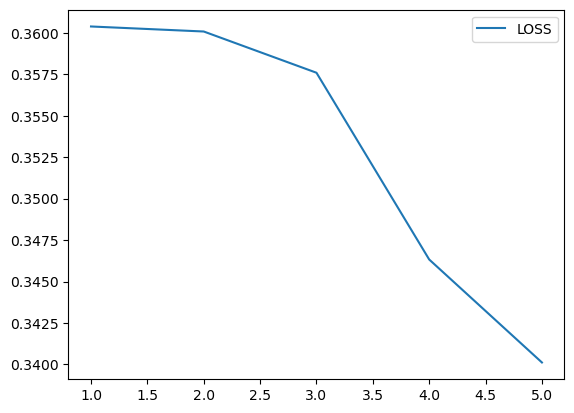

In [ ]:
# ---- Log training loss

epochs_range = range(1, epochs + 1)
history_dict = history.history

loss = history_dict['loss']

plt.plot(epochs_range, loss, label="LOSS")

plt.legend()
plt.show()

## Prediction (Reconstruction)

In [ ]:
# ---- Get one images batch for prediction

test_images = []
for images_batch in train_generator:
    test_images.append(images_batch[0])
    break

test_images = np.array(test_images)
test_images = test_images.reshape(batch_size, image_size[0], image_size[1], 3)

(64, 148, 148, 3)


In [ ]:
# ---- Predict

z_mean, z_var, z  = vae.encoder.predict(test_images)
x_reconst         = vae.decoder.predict(z)

## Latent space

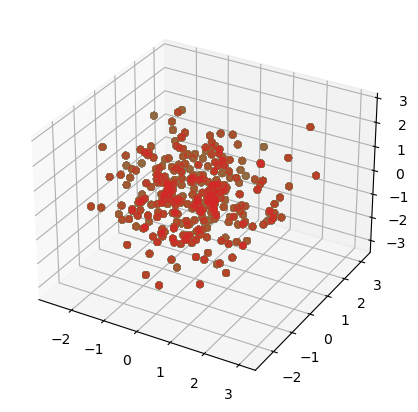

In [ ]:
# ---- See prediction in latent space (only use 3 values)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

for values in z:
    xs = z[1]
    ys = z[2]
    zs = z[3]
    ax.scatter(xs, ys, zs)
    
plt.show()

## Predicted images reconstruction

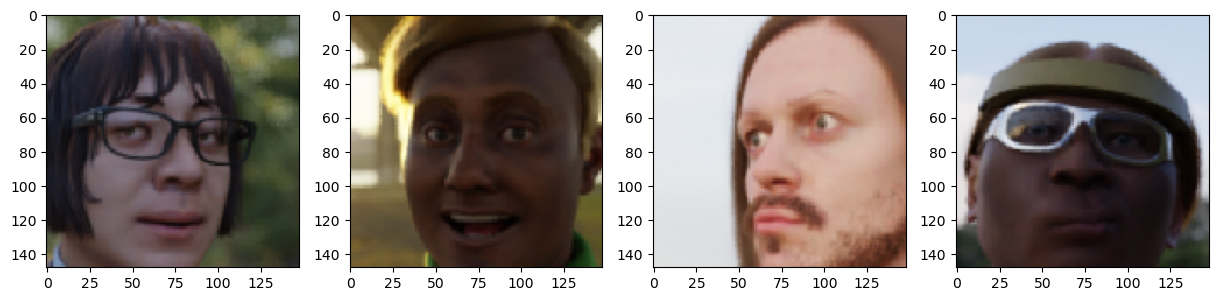

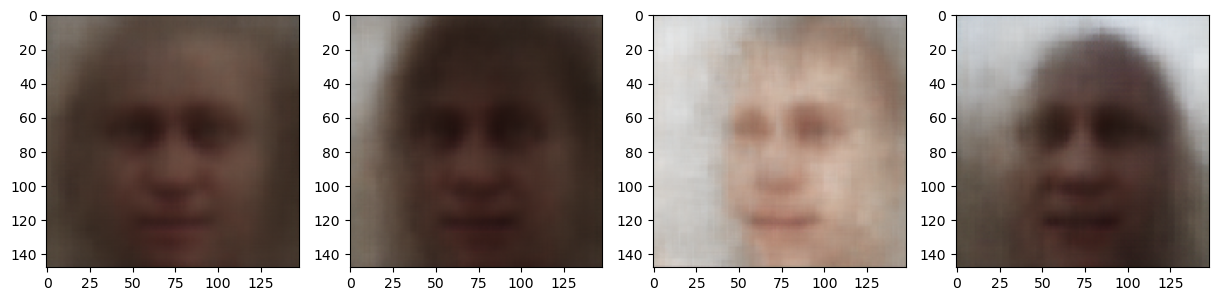

In [ ]:
# ---- Plot original images

fig = plt.figure(figsize=(15,22))
for i in range(1, 5):
  ax = fig.add_subplot(4, 4, i)
  ax.imshow(np.array(test_images[i-1]))

plt.show()

# ---- Plot reconstructed images

fig = plt.figure(figsize=(15,22))
for i in range(1, 5):
  ax = fig.add_subplot(4, 4, i)
  ax.imshow(x_reconst[i-1])

plt.show()


## Random vectors reconstruction

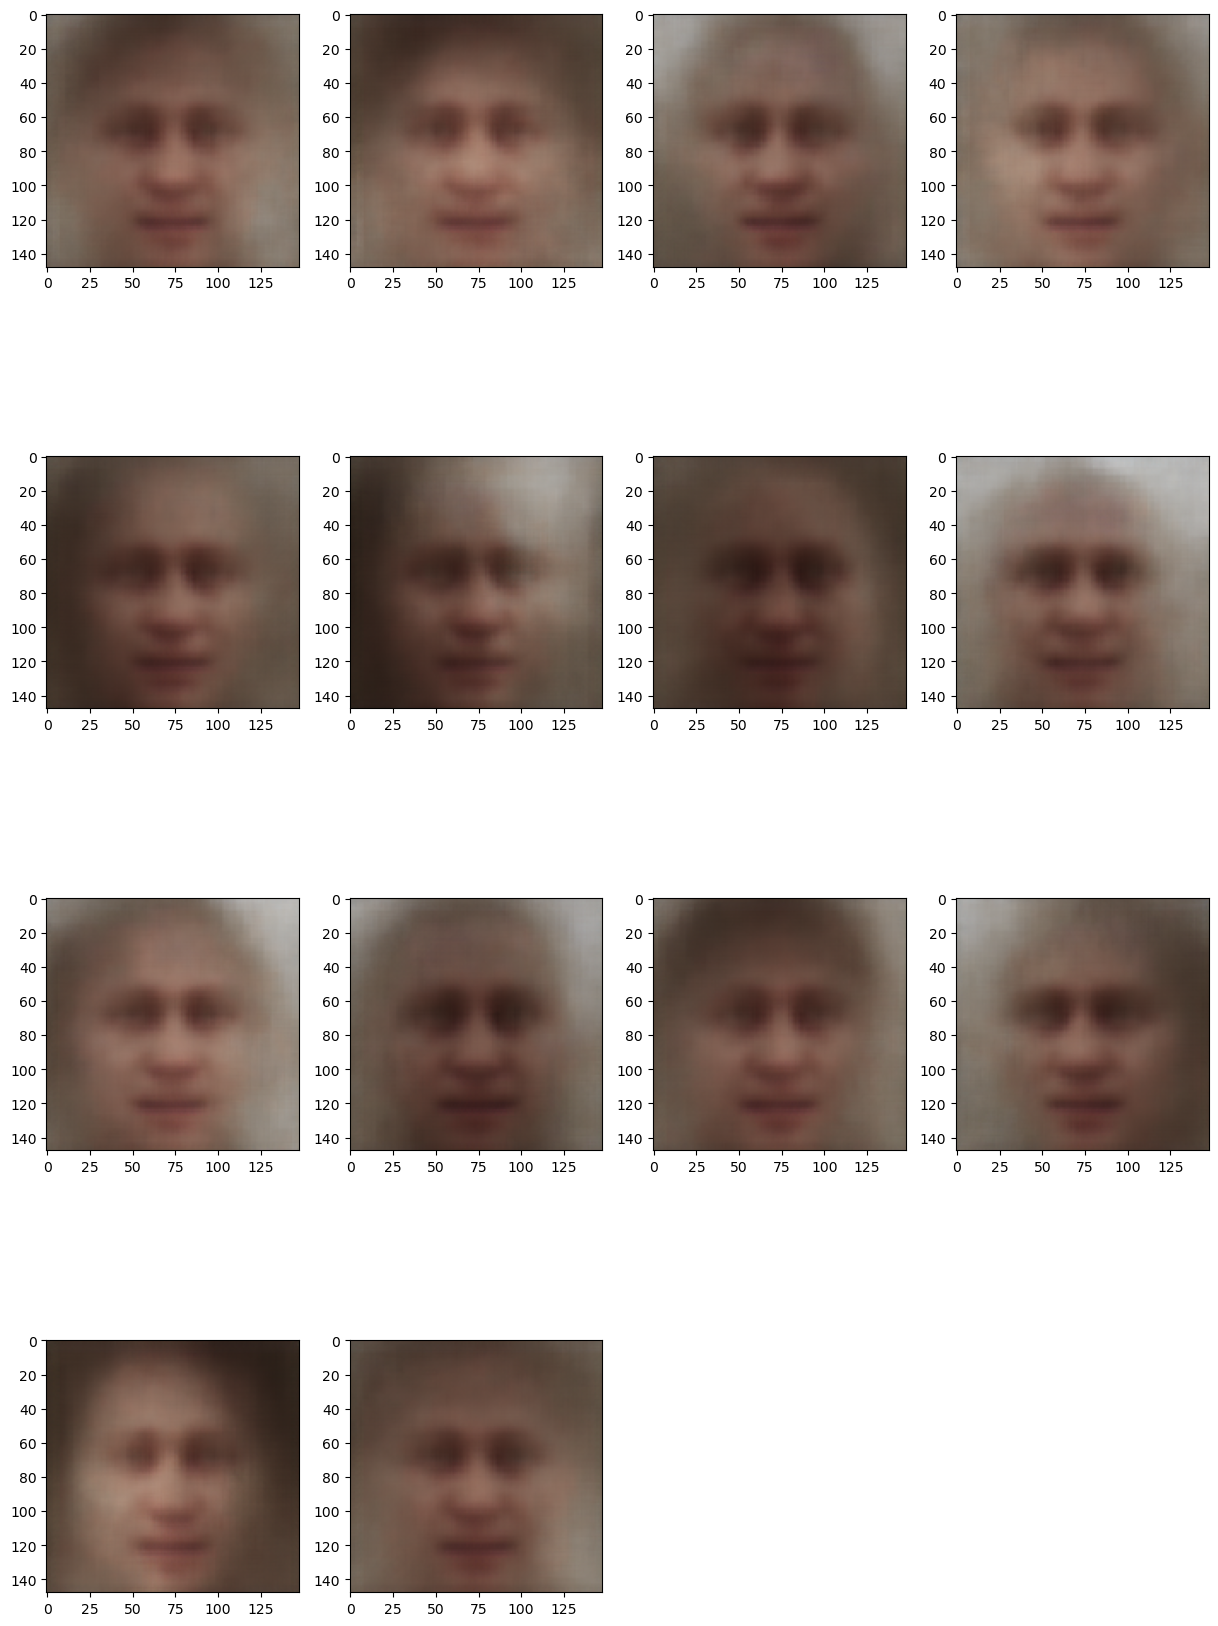

In [ ]:
# ---- Random inputs

z_rand  = np.random.normal(loc=0, scale=0.7, size=(64, latent_dim))

# ---- Reconstruct

x_reconst = vae.decoder.predict(z_rand)

# ---- Plot reconstructed images

fig = plt.figure(figsize=(15,22))
for i in range(1, 15):
  ax = fig.add_subplot(4, 4, i)
  ax.imshow(x_reconst[i-1])

plt.show()